In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import os
os.chdir("E:\code")
os.getcwd()

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)
X = tf.placeholder(tf.float32, [None, 28 * 28]) # MNIST = 28*28
Z = tf.placeholder(tf.float32, [None, 128]) # Noise Dimension = 128


Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [2]:
# ********* G-Network (Hidden Node # = 256)
G_W1 = tf.Variable(tf.random_normal([128, 256], stddev=0.01))
G_W2 = tf.Variable(tf.random_normal([256, 28 * 28], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([256]))
G_b2 = tf.Variable(tf.zeros([28 * 28]))

def generator(noise_z): # 128 -> 256 -> 28*28
    hidden = tf.nn.relu(tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, G_W2) + G_b2)
    return output

# ********* D-Network (Hidden Node # = 256)
D_W1 = tf.Variable(tf.random_normal([28 * 28, 256], stddev=0.01))
D_W2 = tf.Variable(tf.random_normal([256, 1], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([256]))
D_b2 = tf.Variable(tf.zeros([1]))

def discriminator(inputs): # 28*28 -> 256 -> 1
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, D_W2) + D_b2)
    return output

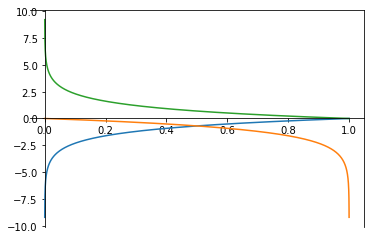

In [3]:
G = generator(Z)
loss_D = -tf.reduce_mean(tf.log(discriminator(X)) + tf.log(1 - discriminator(G)))
loss_G = -tf.reduce_mean(tf.log(discriminator(G)))
train_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=[D_W1, D_b1, D_W2, D_b2])
train_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=[G_W1, G_b1, G_W2, G_b2])

# x = discriminator(G)
# 0<x<1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x=np.arange(0.0001,1,0.0001)
y=np.log(x)
z=np.log(1-x)
w=-y
plt.plot(x,y)
plt.plot(x,z)
plt.plot(x,w)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))


In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_val_D, loss_val_G = 0, 0
losses = []
# ********* Training and Testing
noise_test = np.random.normal(size=(10, 128)) # 10 = Test Sample Size, 128 = Noise Dimension
for epoch in range(200): # 200 = Num. of Epoch
    for i in range(int(mnist.train.num_examples / 100)): # 100 = Batch Size
        batch_xs, _ = mnist.train.next_batch(100)
        noise = np.random.normal(size=(100, 128))

        _, loss_val_D= sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G= sess.run([train_G, loss_G], feed_dict={Z: noise})

    if epoch == 0 or (epoch + 1) % 10 == 0: # 10 = Saving Period
        samples = sess.run(G, feed_dict={Z: noise_test})

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))
        plt.savefig('{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)
    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))
    losses.append((loss_val_D, loss_val_G))    
    


Epoch: 0000 D loss: 0.4501 G loss: 2.081
Epoch: 0001 D loss: 0.2305 G loss: 2.832
Epoch: 0002 D loss: 0.1842 G loss: 3.008
Epoch: 0003 D loss: 0.448 G loss: 1.794
Epoch: 0004 D loss: 0.5976 G loss: 1.37
Epoch: 0005 D loss: 0.2738 G loss: 2.116
Epoch: 0006 D loss: 0.2177 G loss: 2.65
Epoch: 0007 D loss: 0.1787 G loss: 2.727
Epoch: 0008 D loss: 0.2607 G loss: 2.402
Epoch: 0009 D loss: 0.2299 G loss: 2.827
Epoch: 0010 D loss: 0.294 G loss: 2.393
Epoch: 0011 D loss: 0.3377 G loss: 2.784
Epoch: 0012 D loss: 0.5041 G loss: 2.154
Epoch: 0013 D loss: 0.467 G loss: 2.369
Epoch: 0014 D loss: 0.3225 G loss: 2.597
Epoch: 0015 D loss: 0.4244 G loss: 2.71
Epoch: 0016 D loss: 0.384 G loss: 2.657
Epoch: 0017 D loss: 0.3568 G loss: 2.565
Epoch: 0018 D loss: 0.4724 G loss: 2.08
Epoch: 0019 D loss: 0.4409 G loss: 2.371
Epoch: 0020 D loss: 0.3765 G loss: 2.721
Epoch: 0021 D loss: 0.3181 G loss: 2.85
Epoch: 0022 D loss: 0.3735 G loss: 2.653
Epoch: 0023 D loss: 0.5105 G loss: 2.551
Epoch: 0024 D loss: 0.340

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()